In [70]:
# Importing packages
from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from array import array

In [33]:
df1=pd.read_csv("D:\Downloads\qualite-de-lair-mesuree-dans-la-station-chatelet2016.csv", index_col='DATE/HEURE',parse_dates=True, error_bad_lines=False)
df2=pd.read_csv("D:\Downloads\qualite-de-lair-mesuree-dans-la-station-chatelet2017.csv", index_col='DATE/HEURE',parse_dates=True, error_bad_lines=False)
df3=pd.read_csv("D:\Downloads\qualite-de-lair-mesuree-dans-la-station-chatelet2018.csv", index_col='DATE/HEURE',parse_dates=True, error_bad_lines=False)
df4=pd.read_csv("D:\Downloads\qualite-de-lair-mesuree-dans-la-station-chatelet2019.csv", index_col='DATE/HEURE',parse_dates=True, error_bad_lines=False)
df5=pd.read_csv("D:\Downloads\qualite-de-lair-mesuree-dans-la-station-chatelet2020.csv", index_col='DATE/HEURE',parse_dates=True, error_bad_lines=False)
df6=pd.read_csv("D:\Downloads\qualite-de-lair-mesuree-dans-la-station-chatelet2021.csv", index_col='DATE/HEURE',parse_dates=True, error_bad_lines=False)

In [34]:
df=df6.append([df5, df4, df3, df2, df1])

In [35]:
#df.columns =['DATE/HEURE','NON','NO2','PM10','CO2','TEMP','HUMI']
# delete a single row by index value 0
#df = df.drop(labels=0, axis=0)
#df.index= pd.to_datetime(df.index, infer_datetime_format = True, utc = True).astype('datetime64[ns]')
df.index.freq='H'
#df.index = pd.to_datetime(df.index).floor("D")
#df.groupby(df["DATE/HEURE"]).mean()
df.head()

,NO,NO2,PM10,CO2,TEMP,HUMI
DATE/HEURE,,,,,,
2021-12-31 23:00:00+01:00,9,23,31,519,19.1,62.1
2021-12-31 22:00:00+01:00,18,28,39,526,18.5,65.0
2021-12-31 21:00:00+01:00,37,36,51,589,18.9,64.4
2021-12-31 20:00:00+01:00,21,33,49,589,18.7,64.7
2021-12-31 19:00:00+01:00,17,30,49,628,18.8,64.1


In [36]:
#df.index = df['DATE/HEURE']
#df.drop('DATE/HEURE',axis=1, inplace=True)

df.head()

,NO,NO2,PM10,CO2,TEMP,HUMI
DATE/HEURE,,,,,,
2021-12-31 23:00:00+01:00,9,23,31,519,19.1,62.1
2021-12-31 22:00:00+01:00,18,28,39,526,18.5,65.0
2021-12-31 21:00:00+01:00,37,36,51,589,18.9,64.4
2021-12-31 20:00:00+01:00,21,33,49,589,18.7,64.7
2021-12-31 19:00:00+01:00,17,30,49,628,18.8,64.1


In [37]:
#df.index = df.index.astype('datetime64[ns]')
df = df.iloc[::-1]
df.head()

,NO,NO2,PM10,CO2,TEMP,HUMI
DATE/HEURE,,,,,,
2016-01-01 00:00:00+01:00,32,37,139,649,23.1,36.1
2016-01-01 01:00:00+01:00,16,32,132,575,22.9,35.6
2016-01-01 02:00:00+01:00,13,25,128,651,23.2,36.3
2016-01-01 03:00:00+01:00,14,27,125,668,23.4,36.2
2016-01-01 04:00:00+01:00,17,32,93,652,23.0,36.7


In [83]:
pandas_profiling.ProfileReport(df)

In [74]:

#df = df[~df.index.duplicated(keep="first")]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52391 entries, 2016-01-01 00:00:00+01:00 to 2021-12-31 23:00:00+01:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NO      52391 non-null  int64  
 1   NO2     52391 non-null  int64  
 2   PM10    52391 non-null  int64  
 3   CO2     52391 non-null  int64  
 4   TEMP    52391 non-null  float64
 5   HUMI    52391 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 2.8+ MB


In [ ]:
print(np.sum(df.isna()))

In [ ]:
df['NON']= df['NON'].astype(float)
df['NO2']=df['NO2'].astype(float)
df['PM10']=df['PM10'].astype(float)
df['CO2']=df['CO2'].astype(float)
df['TEMP']=df['TEMP'].astype(float)
df['HUMI']=df['HUMI'].astype(float)


In [ ]:
df['NON']=df['NON'].replace(0.0,df['CO2'].mean())
df['NO2']=df['NO2'].replace(0.0,df['CO2'].mean())
df['PM10']=df['PM10'].replace(0.0,df['CO2'].mean())
df['TEMP']=df['TEMP'].replace(0.0,df['CO2'].mean())
df['HUMI']=df['HUMI'].replace(0.0,df['CO2'].mean())

df['CO2']=df['CO2'].replace('<',df['CO2'].mean())

<AxesSubplot:xlabel='DATE/HEURE'>

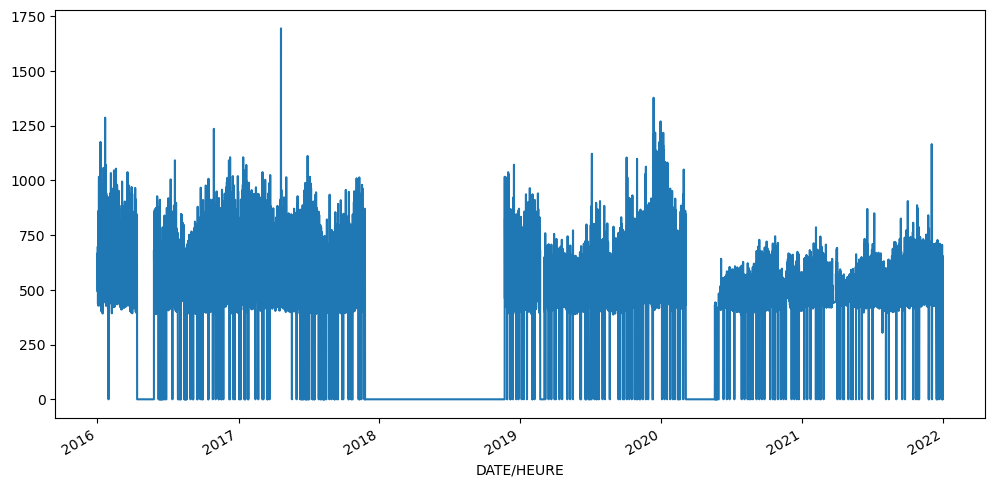

In [39]:
df['CO2'].plot(figsize=(12,6))

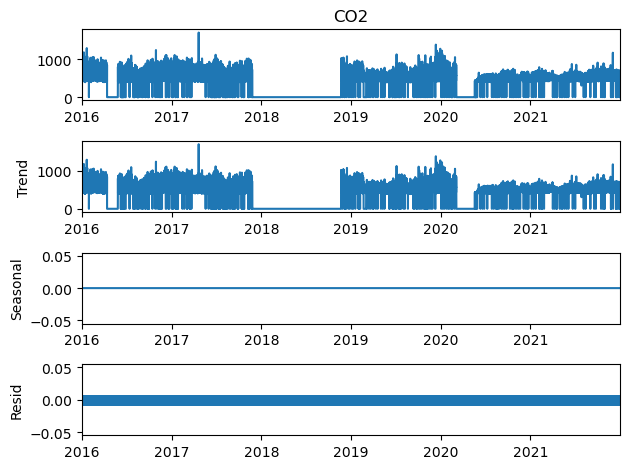

In [40]:
#RNN

results= seasonal_decompose(df['CO2'], extrapolate_trend='freq', period=1)
results.plot();



In [41]:
df2= df[['CO2']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52391 entries, 2016-01-01 00:00:00+01:00 to 2021-12-31 23:00:00+01:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NO      52391 non-null  int64  
 1   NO2     52391 non-null  int64  
 2   PM10    52391 non-null  int64  
 3   CO2     52391 non-null  int64  
 4   TEMP    52391 non-null  float64
 5   HUMI    52391 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 2.8+ MB


In [42]:


scaler= MinMaxScaler()

In [43]:
train_data = df2.iloc[:-8760]
test_data = df2.iloc[-8760:]
train_data.info()

scaler.fit(train_data)
scaled_train= scaler.transform(train_data)
scaled_test= scaler.transform(test_data)

<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 2016-01-01 00:00:00+01:00 to 2020-12-24 23:00:00+01:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   CO2     43631 non-null  int64
dtypes: int64(1)
memory usage: 681.7+ KB


In [44]:
n_input= 8760
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [45]:
#definition du model 
model = Sequential()
model.add(LSTM(1000,input_shape=(n_input,n_features)))
model.add(Dense(1))
#model.compile()
model.compile(optimizer='adam', loss='mse')

In [46]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1000)              4008000   
                                                                 
 dense_3 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 4,009,001
Trainable params: 4,009,001
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(generator, epochs=0)

In [50]:
last_train_group = scaled_train[-8760:]

In [51]:
model.predict(last_train_group)

274/274 [==============================] - 3s 5ms/step


array([[0.06331902],
       [0.06261747],
       [0.06261747],
       ...,
       [0.06378675],
       [0.0624304 ],
       [0.06186918]], dtype=float32)

In [52]:
scaled_test[0]

array([0.25132743])

In [78]:
predictions_tests=[]

premier_groupe = scaled_train[-n_input:]
groupe_actuel= premier_groupe.reshape((1, n_input, n_features))

for i in range(len(test_data)):
    #prediction du premier groupe
    groupe_actuel= model.predict(groupe_actuel)[0]
    
    #ajouter la prediction dans la liste
    predictions_tests.append(groupe_actuel)
    
    #on utilise la prediction pour re-initialiser le groupe et enlever la premiere valeur
    groupe_actuel= np.append(groupe_actuel[:,1:,:], [[groupe_actuel]], axis=1)

KeyboardInterrupt: 

In [67]:
predictions_tests_retransforme= scaler.inverse_transform(predictions_tests)

In [ ]:
test_data['predictions']=predictions_tests_retransforme

<AxesSubplot:xlabel='DATE/HEURE'>

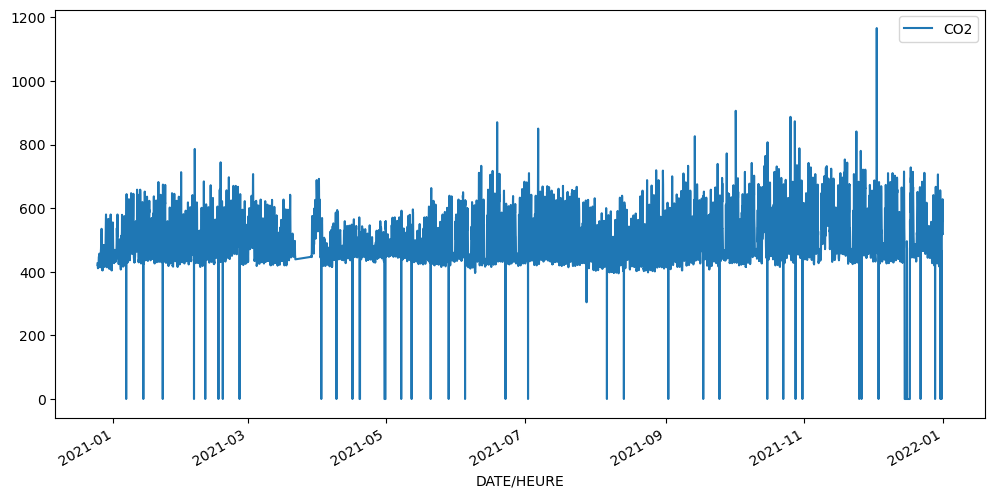

In [64]:
test_data.plot(figsize=(12,6))

In [81]:
rmse= sqrt(mean_squared_error(test_data['CO2'], test_data['predictions']))
print(rmse)

In [75]:
#modèle autoregression

In [127]:
dftest = adfuller(df['CO2'], autolag = "AIC")
print('ADF:', dftest[0])
print('P-Value:', dftest[1])
print("Num of lags:", dftest[2])
print('Num of observation used for ADF regression and critical values calculation:', dftest[3])
print('Critical Values:')
for key, val in dftest[4].items():
    print("\t", key, ": ", val)

ADF: -7.2598211499700325
P-Value: 1.6930124032892653e-10
Num of lags: 58
Num of observation used for ADF regression and critical values calculation: 52332
Critical Values:
	 1% :  -3.43047496409059
	 5% :  -2.8615952316158593
	 10% :  -2.5667993979530026


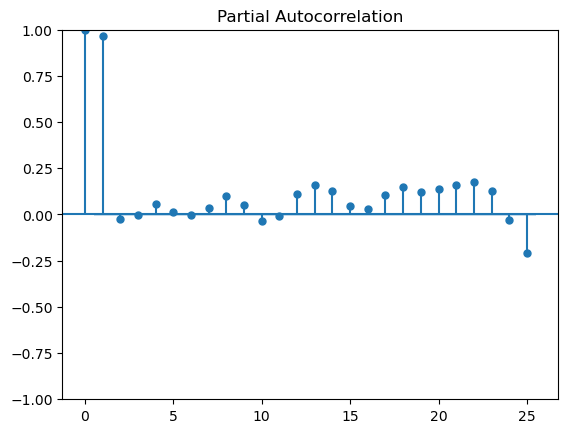

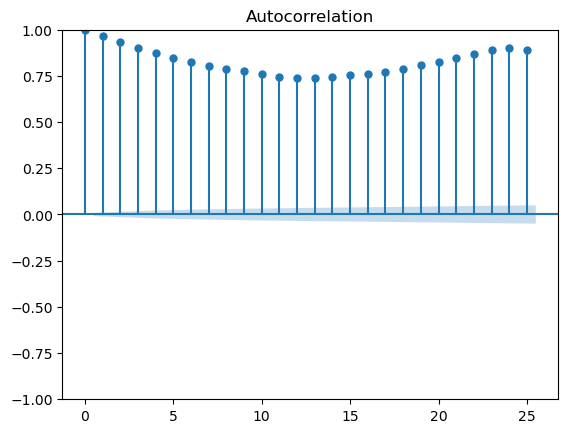

In [128]:
pacf=plot_pacf(df['CO2'], lags=25)
acf= plot_acf(df['CO2'], lags=25)

In [99]:
X=df['CO2'].values
train=X[:len(X)-365]
test=X[len(X)-365:]

In [110]:
model= AutoReg(train, lags=10).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                52026
Model:                    AutoReg(10)   Log Likelihood             -290800.251
Method:               Conditional MLE   S.D. of innovations             64.823
Date:                Mon, 07 Nov 2022   AIC                         581624.502
Time:                        01:05:33   BIC                         581730.814
Sample:                            10   HQIC                        581657.743
                                52026                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6949      0.551     19.399      0.000       9.614      11.776
y.L1           0.9901      0.004    225.957      0.000       0.982       0.999
y.L2          -0.0185      0.006     -3.000      0.0

In [111]:
print(len(train))

52026


In [112]:
pred=model.predict(start=len(train), end=len(X)-1, dynamic=False)

[ 10.69493863  21.28445168  31.57199154  40.87332086  49.6389489
  58.13426228  66.08671573  72.8451259   78.93857696  85.34799566
  91.81593452  98.29142415 104.63650737 110.89381062 117.1385814
 123.31951203 129.30362348 135.08561281 140.72873675 146.25301149
 151.6640297  156.94912962 162.11606446 167.1851662  172.16291752
 177.04036789 181.81307619 186.48387078 191.05719184 195.53550427
 199.91829296 204.20668744 208.40432735 212.51461232 216.53930064
 220.47959609 224.3370789  228.11378062 231.8115937  235.43193562
 238.97615822 242.44585149 245.84271301 249.16833179 252.42416455
 255.61163605 258.73220737 261.78732896 264.7783785  267.70667462
 270.5735185  273.38020471 276.12800396 278.81814986 281.45184484
 284.03027189 286.5545952  289.02595336 291.4454571  293.81419263
 296.13322509 298.40359848 300.6263342  302.80243112 304.93286719
 307.01860056 309.06056959 311.05969268 313.01686869 314.93297769
 316.80888147 318.64542377 320.44343049 322.20371014 323.92705431
 325.6142380

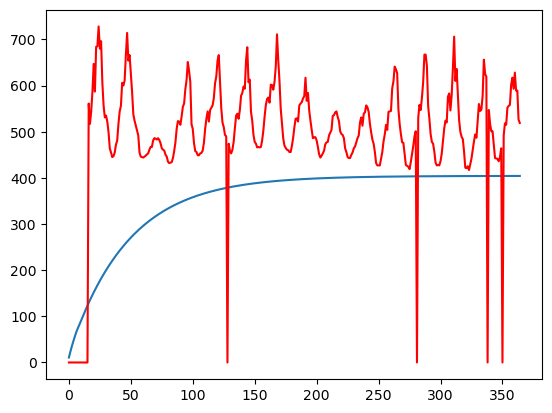

In [113]:
plt.plot(pred)
plt.plot(test, color='red')
print(pred)

In [114]:
#Calculate error
from math import sqrt
from sklearn.metrics import mean_squared_error


rmse= sqrt(mean_squared_error(test, pred))

In [115]:
print(rmse)

184.10671604570706


In [116]:
pred_future=model.predict(start=len(X)+1, end=len(X)+365, dynamic=False)
print("the future prediction for the next year")
print(pred_future)
print('Number of predictions made: \t', len(pred_future))

the future prediction for the next year
[404.17083417 404.17428518 404.17766378 404.1809715  404.1842098
 404.18738016 404.19048399 404.1935227  404.19649765 404.19941017
 404.20226159 404.20505317 404.20778618 404.21046184 404.21308135
 404.21564591 404.21815665 404.22061471 404.22302119 404.22537718
 404.22768374 404.22994189 404.23215267 404.23431705 404.23643602
 404.23851053 404.24054151 404.24252988 404.24447652 404.24638232
 404.24824813 404.25007479 404.25186312 404.25361393 404.255328
 404.2570061  404.25864899 404.26025741 404.26183209 404.26337372
 404.264883   404.26636061 404.26780722 404.26922348 404.27061002
 404.27196747 404.27329643 404.27459751 404.27587128 404.27711833
 404.27833922 404.27953449 404.28070467 404.2818503  404.2829719
 404.28406996 404.28514498 404.28619744 404.28722782 404.28823658
 404.28922417 404.29019104 404.29113763 404.29206435 404.29297162
 404.29385986 404.29472946 404.29558082 404.29641431 404.29723031
 404.29802919 404.29881131 404.29957701 

In [ ]:
#model ARIMA

In [46]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(df['CO2'], trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25632.500, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25936.225, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25823.768, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25760.276, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25934.226, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25635.611, Time=0.91 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25635.646, Time=0.93 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=25634.501, Time=1.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=25634.494, Time=2.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25634.321, Time=0.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=25637.227, Time=1.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=25637.432, Time=1.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=25622.536, Time=3.61 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=25618.407, Time=2.34 sec
 ARIMA(4,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2187
Model:               SARIMAX(4, 1, 4)   Log Likelihood              -12794.111
Date:                Mon, 07 Nov 2022   AIC                          25606.222
Time:                        00:38:15   BIC                          25657.431
Sample:                             0   HQIC                         25624.940
                               - 2187                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8555      0.028    -30.421      0.000      -0.911      -0.800
ar.L2         -0.6245      0.027    -23.286      0.000      -0.677      -0.572
ar.L3         -0.1695      0.030     -5.647      0.000      -0.228      -0.111
ar.L4          0.5438      0.018     30.031      0.000       0.508       0.579
ma.L1          0.5268      0.028     19.010      0.000       0.473       0.581
ma.L2          0.1794      0.022      8.101      0.000       0.136       0.223
ma.L3         -0.2683      0.024    -11.220      0.000      -0.315      -0.221
ma.L4         -0.8188      0.022    -37.232      0.000      -0.862      -0.776
sigma2      7205.0169     81.372     88.545      0.000    7045.532    7364.502
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             29263.69
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [141]:
model=ARIMA(train_data, order=(4, 1, 4))
model=model.fit()
model.summary()

C:\Users\joshn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\joshn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\joshn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\joshn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\joshn\AppData\Roaming\Python\Python39\site-packages\s

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                43631
Model:                 ARIMA(4, 1, 4)   Log Likelihood             -243797.701
Date:                Mon, 07 Nov 2022   AIC                         487613.402
Time:                        01:22:23   BIC                         487691.553
Sample:                             0   HQIC                        487638.038
                              - 43631                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4279      0.012     36.442      0.000       0.405       0.451
ar.L2         -0.0788      0.016     -5.024      0.000      -0.110      -0.048
ar.L3         -0.5293      0.016    -32.244      0.000      -0.562      -0.497
ar.L4          0.8528      0.010     86.264      0.000       0.833       0.872
ma.L1         -0.5100      0.012    -42.284      0.000      -0.534      -0.486
ma.L2          0.0026      0.018      0.149      0.882      -0.032       0.037
ma.L3          0.4555      0.018     25.695      0.000       0.421       0.490
ma.L4         -0.9048      0.012    -77.504      0.000      -0.928      -0.882
sigma2      4335.5141      8.420    514.925      0.000    4319.012    4352.016
===================================================================================
Ljung-Box (L1) (Q):                 184.04   Jarque-Bera (JB):           2854877.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [163]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
pred1=model.predict(start=len(train_data), end=end,type='levels')
print(pred)

2022-12-01    526.970807
2022-12-02    515.088035
2022-12-03    523.060057
2022-12-04    513.066241
2022-12-05    520.624110
2022-12-06    510.941785
2022-12-07    517.723829
2022-12-08    509.442593
2022-12-09    516.390771
2022-12-10    508.706318
2022-12-11    514.557527
2022-12-12    507.422905
2022-12-13    513.438352
2022-12-14    507.365810
2022-12-15    512.644515
2022-12-16    506.538374
2022-12-17    511.468473
2022-12-18    506.456794
2022-12-19    511.294290
2022-12-20    506.298071
2022-12-21    510.316666
2022-12-22    505.915086
2022-12-23    510.171874
2022-12-24    506.243915
2022-12-25    509.712988
2022-12-26    505.778877
2022-12-27    509.270167
2022-12-28    506.128578
2022-12-29    509.312004
2022-12-30    505.956678
2022-12-31    508.696969
Freq: D, Name: Predication par ARIMA, dtype: float64


C:\Users\joshn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:xlabel='DATE/HEURE'>

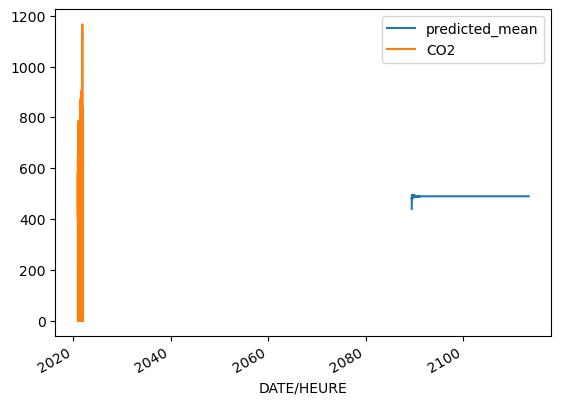

In [164]:
pred1.plot(legend=True)
test_data['CO2'].plot(legend=True)

In [165]:
rmse2=sqrt(mean_squared_error(pred1, test_data))
print(rmse2)

90.18592502542586


In [154]:
model2=ARIMA(df['CO2'], order=(4, 1, 4))
model2=model2.fit()

C:\Users\joshn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\joshn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\joshn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\joshn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\joshn\AppData\Roaming\Python\Python39\site-packages\s

In [170]:
index_future_dates=pd.date_range(start='2022-12-01', end='2023-12-01')
pred=model2.predict(start=len(df['CO2']),end=len(df['CO2'])+365, type='levels').rename('Predication par ARIMA')
pred.index=index_future_dates

C:\Users\joshn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [82]:
pred.plot(figsize=(12,5), legends=True)

plt.figure(figsize=(20,6))
plt.plot(df.groupby('DATE/HEURE').count(), 'o', color='skyblue')
plt.title('Nb of measurements per DATE/HEURE')
plt.ylabel('number of measurements')
plt.xlabel('DATE/HEURE')
plt.show()